In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import itertools as itr
import copy
from boundaries import WallBoundary, PressureBoundary, VelocityBoundary
from generators import WallGenerators
from simulation import Simulation
import pandas as pd
import random
from openpyxl import load_workbook

In [ ]:
yResolution = random.randint(20,50)
xResolution = random.randint(20,50)
ACspeed = 1

walls = WallBoundary(yResolution, xResolution)
walls.borderWall()
conditions = walls.generateRoom()
walls.generateIndex()
walls.generateACDirections()
walls.indexPossibleACPos()

bestPos = []
bestDirection = []
bestTemp = 0

In [ ]:
plt.imshow(walls.invertedBoundary, cmap="hot", interpolation="nearest")
plt.scatter([i[1] for i in walls.possibleACIndex], [i[0] for i in walls.possibleACIndex])
print(walls.possibleACIndex)

In [ ]:
def sim(pos):
    for directionIndex, direction in enumerate(WallBoundary.unitVect):
        #print(f"Trying direction: {direction}...")
        pathOfFlow = [i+j for i, j in zip(pos, direction)]
        reverseFlow = [i-j for i, j in zip(pos, direction)]
        isNormal = (not walls.boundary[pathOfFlow[0], pathOfFlow[1]]) and (walls.boundary[reverseFlow[0], reverseFlow[1]])

        if (isNormal):
            velocityInlet = [VelocityBoundary(pos[0], pos[1], ACspeed, directionIndex)]
            initCondition = np.ones((yResolution, xResolution, Simulation.latticeSize)) / 9
            simulation = Simulation(
                yResolution, xResolution, initCondition, walls, velocityBoundaries=velocityInlet, pressureBoundaries=[]
            )
            simTime, stable = simulation.simulateUntilEquilibrium(equilibriumThreshold=2.5, limit = 500)
            results = simulation.getMomentum()
            #print("Done!")
            if not stable or simTime == 500:
                #print("It exploded :() or didn't equalize")
                return False, simTime
            else:
                return True, simTime

In [121]:
learningRate = 0.5

In [ ]:
results, temp = bruteForce()
print(results)

In [ ]:
print(min(results))
worst =  max(results)
best = min(results)
datarange = max(results) - min(results)
ans = [walls.possibleACIndex[i] for i in range(len(results)) if results[i] == best]
print(ans)

7.0
[(1, 48)]


In [ ]:
gdworked, gdpos, gdtime = gradientDescent(1)
if (gdworked):
    print(f"GD worked, Pos: {gdpos}, Time: {gdtime}")
    print((results[gdpos] - worst)/ datarange)
else:
    print("GD didn't work")

GD
Pos: (2, 7)
Simulating at pos...
Move: 210
Pos: (1, 40)
Simulating at pos...
Move: 0
Pos: (1, 41)
Simulating at pos...
Move: 0
Pos: (1, 42)
Simulating at pos...
Move: 0
Pos: (1, 43)
Simulating at pos...
Move: 0
Pos: (1, 44)
Simulating at pos...
Move: 0
Pos: (1, 45)
Simulating at pos...
Move: 0
Pos: (1, 46)
Simulating at pos...
Move: 0
Pos: (1, 47)
Simulating at pos...
Move: 0
Pos: (1, 48)
Simulating at pos...
Move: -215
GD worked, Pos: 135, Time: 10
74.08191287878788


In [ ]:
ADAMworked, ADAMpos, ADAMtime = ADAM(1, 0.9, 0.999)
if (ADAMworked):
    print(f"ADAM worked, Pos: {ADAMpos}, Time: {ADAMtime}")
    print((results[gdpos] - worst)/ datarange)
else:
    print("ADAM didn't work")

ADAM
Pos: (2, 7)
Simulating at pos...
Move: 31622.77660167901
Pos: (44, 15)
Simulating at pos...
Move: 0.8715128819485739
Pos: (44, 14)
Simulating at pos...
Move: 0.5515455352253738
Pos: (44, 13)
Simulating at pos...
Move: 0.4079244070902482
Pos: (44, 12)
Simulating at pos...
Move: 0.32021583145390553
Pos: (44, 11)
Simulating at pos...
Move: 0.25495824007716267
Pos: (44, 10)
Simulating at pos...
Move: 0.20221460473393219
Pos: (44, 9)
Simulating at pos...
Move: 0.15473947664660948
Pos: (44, 8)
Simulating at pos...
Move: 0.10312954266115439
Pos: (44, 7)
Simulating at pos...
Move: 0.030901922487616657
Pos: (44, 6)
Simulating at pos...
Move: -0.02034413134893128
ADAM worked, Pos: 50, Time: 11
-67.66808712121212


In [ ]:
ADAMWworked, ADAMWpos, ADAMWtime = ADAMW(1, 0.9, 0.999, 0.004)
if (ADAMWworked):
    print(f"ADAMW worked, Pos: {ADAMWpos}, Time: {ADAMWtime}")
    print((results[gdpos] - worst)/ datarange)
else:
    print("ADAMW didn't work")

#print(f"Actual Best Pos: {ans}")

ADAMW
Pos: (2, 7)
Simulating at pos...
Move: 31622.77660167901
Pos: (44, 15)
Simulating at pos...
Move: 0.8726447682940093
Pos: (44, 14)
Simulating at pos...
Move: 0.5531353287347911
Pos: (44, 13)
Simulating at pos...
Move: 0.4098449406723372
Pos: (44, 12)
Simulating at pos...
Move: 0.32240379626602456
Pos: (44, 11)
Simulating at pos...
Move: 0.25737336525353177
Pos: (44, 10)
Simulating at pos...
Move: 0.2048261315386685
Pos: (44, 9)
Simulating at pos...
Move: 0.15752186061193135
Pos: (44, 8)
Simulating at pos...
Move: 0.10605658554431943
Pos: (44, 7)
Simulating at pos...
Move: 0.03392802487698295
Pos: (44, 6)
Simulating at pos...
Move: -0.01723137189380594
ADAMW worked, Pos: 50, Time: 11
-67.66808712121212


[(1, 47), (44, 7), (44, 7)]
[(1, 48)]


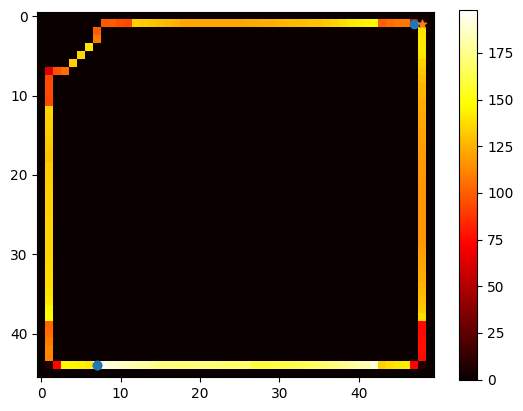

In [131]:
fig, ax = plt.subplots()

init = walls.possibleACIndex

room = np.zeros((yResolution, xResolution))
for i, pos in enumerate(init):
    room[pos] = results[i]
#init = np.append(init, export, axis=1)
#print(room)
allresults = [gdpos, ADAMpos, ADAMWpos]
allans = [walls.possibleACIndex[i] for i in allresults]
print(allans)
print(ans)

x = [i[1] for i in allans]
y = [i[0] for i in allans]

xans = [i[1] for i in ans]
yans = [i[0] for i in ans]

heatmap  = ax.imshow(room, cmap="hot", interpolation="nearest")
ax.scatter(x, y)
ax.scatter(xans, yans, marker="*")

fig.colorbar(heatmap)

In [132]:
room = np.zeros((yResolution, xResolution))
for i, pos in enumerate(init):
    room[pos] = temp[i]
heatmap  = ax.imshow(room, cmap="hot", interpolation="nearest")

fig.colorbar(heatmap)

In [133]:
# currentIndex = 0
# worked = False
# length = len(walls.possibleACIndex)
# visitedAll = np.zeros(length)
# while True:
#     visitedAll[currentIndex] = 1
#     if (sum(visitedAll) == length):
#         break
    
#     currentPos = walls.possibleACIndex[currentIndex]
#     print(f"Pos: {currentPos}")
#     print("Simulating at pos...")
#     usable, currentResults = sim(currentPos)
#     if (not usable):
#         print("Not stable")
#         currentIndex += 1
        
#     else:
#         print("Stable")
#         forwardPos = walls.possibleACIndex[(currentIndex + 1) % length]
#         forwardUsable, forwardResults = sim(forwardPos)
#         forwardDif = forwardResults - currentResults

#         backwardPos = walls.possibleACIndex[(currentIndex - 1) % length] 
#         backwardUsable, backwardResults = sim(backwardPos)
#         backwardDif = currentResults - backwardResults

#         forwardMessage = (str(forwardDif) if forwardUsable else "Unusable") 
#         print(f"Forward Difference: {forwardMessage}")

#         backwardMessage = (str(backwardDif) if backwardUsable else "Unusable") 
#         print(f"Backward Difference: {backwardMessage}")

#         if ((forwardDif < 0 and forwardUsable) and (backwardDif > 0 and backwardUsable)):
#             print("Reached Equil.")
#             worked = True
#             break
#         else:
#             gradient = (forwardDif * forwardUsable) + (backwardDif * backwardUsable)
#             print(f"Gradient: {gradient}")
#             indexMove = learningRate * gradient
#             if (indexMove < 1):
#                 print("Gradient too small. Pushing...")
#                 indexMove = np.sign(indexMove)
            
#             currentIndex = (currentIndex + int(indexMove)) % length
    
#     print("------------")

# if (not worked):
#     print("Didn't work.")
# else:   
#     print(f"Worked! {walls.possibleACIndex[currentIndex]}")
